# Attention Pooling: Nadaraya-Watson Kernel Regression

## Key Idea:
The concept of nonparamteric attention is introduced. To find output at a particular point, we take weighted sum of knwon outputs of training set. The weights that are assigned to each output is determined by a nonparameteric function. Hence the name.  
$$f(x) = \Sigma_{i = 1}^n{\alpha(x, x_i)y_i}$$


In [1]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
tf.random.set_seed(seed = 1322)
import matplotlib.pyplot as plt

from saved_class_Animator import Animator
from saved_func_show_heatmaps import show_heatmaps

Tensorflow Version:  2.4.1


## 10.2.1. Generating the Dataset

In [2]:
n_train = 50
x_train = tf.sort(tf.random.uniform(shape = (n_train,), maxval = 5))

def f(x):
    return 2*tf.math.sin(x) + x**0.8

y_train = f(x_train) + tf.random.normal(shape = (n_train,), stddev= 0.5)

x_test = tf.range(start = 0, limit = 5, delta = 0.1)
y_truth = f(x_test)

In [3]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth, label = "Truth")
    plt.plot(x_test, y_hat, label = "Pred", color = "Purple")
    plt.legend()
    plt.plot(x_train, y_train, 'o', alpha=0.5, color = "Orange")

## 10.2.2. Average pooling
$$f(x) = \frac{1}{n}\Sigma_{i= 1}^n{y_i}$$

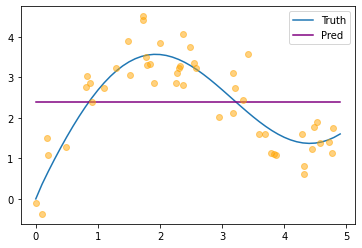

In [4]:
n_test = len(x_test)
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats = n_test)
plot_kernel_reg(y_hat)

## 10.2.3. Nonparamteric attention pooling

$$f(x) = \Sigma_{i=1}^n{\frac{K(x - x_i)}{\Sigma_{j = 1}^n{K(x - x_j)}}y_i}$$
Where,
$$K(u) = \frac{1}{\sqrt{2\pi}}exp(-\frac{u^2}{2})$$

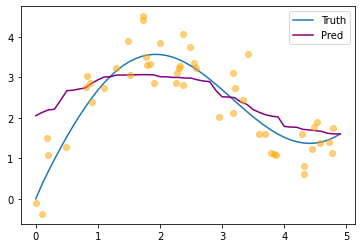

In [5]:
# Shape of `X_repeat`: (`n_test`, `n_train`), where each row contains the same testing inputs (i.e., same queries)
X_repeat = tf.repeat(tf.expand_dims(x_train, axis = 0), repeats = n_train, axis = 0)
# Note that `x_train` contains the keys. Shape of `attention_weights`:
# (`n_test`, `n_train`), where each row contains attention weights to be
# assigned among the values (`y_train`) given each query
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis = 1))**2/2, axis = 1)
# Each element of `y_hat` is weighted average of values, where weights are attention weights
y_hat_kernel_reg = tf.matmul(attention_weights, tf.expand_dims(y_train, axis = 1))
plot_kernel_reg(y_hat_kernel_reg)

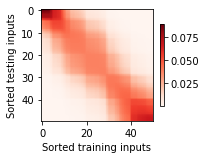

In [6]:
show_heatmaps(tf.expand_dims(tf.expand_dims(attention_weights, axis = 0), axis = 0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

## 10.2.4. Parametric attention pooling

### 10.2.4.1. Batch Matrix Multiplication

In [7]:
X = tf.ones((2, 1, 4))
Y = tf.ones((2, 4, 6))
tf.matmul(X, Y).shape

TensorShape([2, 1, 6])

In [8]:
weights = tf.ones((2, 10)) * 0.1
values = tf.reshape(tf.range(20.0), shape = (2, 10))
tf.matmul(tf.expand_dims(weights, axis = 1), tf.expand_dims(values, axis = -1)).numpy()

array([[[ 4.5]],

       [[14.5]]], dtype=float32)

### 10.2.4.2. Defining the Model

In [9]:
class NWKernelRegression(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value = tf.random.uniform(shape = (1,)))
        
    def call(self, queries, keys, values, **kwargs):
        # For training queries are `x_train`. Keys are distance of taining data for each point. Values are `y_train`.
        # Shape of the output `queries` and `attention_weights`: (no. of queries, no. of key-value pairs)
        queries = tf.repeat(tf.expand_dims(queries, axis = 1), repeats = keys.shape[1], axis = 1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w)**2 /2, axis = 1)
        # Shape of `values`: (no. of queries, no. of key-value pairs)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis = 1), tf.expand_dims(values, axis = -1)))

### 10.2.4.3. Training

In [10]:
# Shape of `X_tile`: (`n_train`, `n_train`), where each column contains the same training inputs
X_tile = tf.repeat(tf.expand_dims(x_train, axis = 0), repeats = n_train, axis = 0)
# Shape of `Y_tile`: (`n_train`, `n_train`), where each column contains the same training outputs
Y_tile = tf.repeat(tf.expand_dims(y_train, axis = 0), repeats = n_train, axis = 0)

# Shape of `keys`: ('n_train', 'n_train' - 1)
keys = tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype = tf.bool)], shape = (n_train, -1))
# Shape of `values`: ('n_train', 'n_train' - 1)
values = tf.reshape(Y_tile[tf.cast(1 - tf.eye(n_train), dtype = tf.bool)], shape = (n_train, -1))

Epoch 5: Loss = 7.4375, variable_value: 7.0987


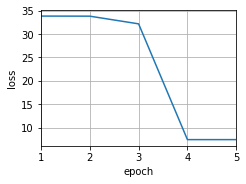

In [11]:
model = NWKernelRegression()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.5)
animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

def train_step(model, queries, keys, values, targets):
    with tf.GradientTape() as t:
        loss = loss_object(targets, model(queries, keys, values))/2 * len(targets) # To be consistent with d2l book
    grads = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, model.trainable_variables[0]

epochs = 5
for epoch in range(epochs):
    current_loss, weight_value = train_step(model, x_train, keys, values, y_train)
    animator.add(epoch + 1, float(current_loss))
    print("Epoch {0}: Loss = {1:.4f}, variable_value: {2:.4f}".
          format(epoch+1, current_loss.numpy(), weight_value.numpy().tolist()[0]))

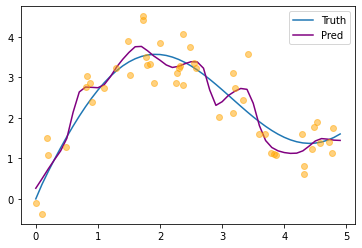

In [12]:
# Shape of `keys`: (`n_test`, `n_train`), where each column contains the same training inputs (i.e., same keys)
keys = tf.repeat(tf.expand_dims(x_train, axis = 0), repeats = n_test, axis = 0)
# Shape of `value`: (`n_test`, `n_train`)
values = tf.repeat(tf.expand_dims(y_train, axis = 0), repeats = n_test, axis = 0)
y_hat = model(x_test, keys, values)
plot_kernel_reg(y_hat)

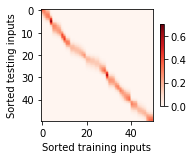

In [13]:
show_heatmaps(tf.expand_dims(tf.expand_dims(model.attention_weights, axis = 0), axis = 0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')